In [14]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

In [16]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core-rare"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [ ]:
%%R
levels(physeq.Bulk.m$Till)

In [ ]:
%%R
mdf = psmelt(physeq.Bulk)

In [ ]:
%%R
samples = mdf %>% group_by(Sample) %>% summarise(seqs = sum(Abundance))
range(samples$seqs)

In [ ]:
%%R
samples$Sample <- factor(samples$Sample, levels = samples$Sample[order(samples$seqs)])
ggplot(data = samples, aes(Sample, seqs)) + geom_bar(stat = 'identity')

In [ ]:
%%R
head(mdf)

In [ ]:
%%R
mdf_sum = mdf %>% group_by(Sample, Month, Year, Till) %>% summarise(seqs = sum(Abundance))
mdf_sum$M = paste(mdf_sum$Month, mdf_sum$Year, sep = '-')
mdf_sum$MY = paste(mdf_sum$Month, mdf_sum$Year, mdf_sum$Till, sep = '-')
mdf_sum$MY <- factor(mdf_sum$MY, levels = mdf_sum$MY[order(mdf_sum$seqs)])
mdf_sum$Sample <- factor(mdf_sum$Sample, levels = mdf_sum$Sample[order(mdf_sum$seqs)])

In [ ]:
%%R
head(mdf_sum) %>% arrange(seqs)

#Check to see if sample distribution is even or 1 outlier (t-test)
# 10,000-30,000 seqs/sample
# randomly draw from distribution to larger # samples

# Or rarefying to equal amount (10,000 seqs)

# Check coverage for bulk samples...

# pick sparsity where response is most even among samples

# Check number of responders at different rarefaction levels for July

# Analysis just for July (# responders with full vs subset dataset) - look at RA abundance over all 16 samples. RA vs 
# number of seqs rarefied (limit of detection)

In [ ]:
%%R
reseq = filter(mdf_sum, seqs < 15000) %>% as.data.frame

In [ ]:
%%R
meta = read.csv('/home/chantal/Chazy/data/Metadata_515806_all.txt', sep = '\t', header = TRUE)
head(meta)

In [ ]:
%%R
reseq2 = filter(meta, Full.sample %in% reseq$Sample) %>% select(Full.sample, Pool, Barcode) %>%
         arrange(Barcode) %>% as.data.frame()
#write.csv(reseq2, file = 'data/Bulk515_SamplesReseq.csv')

In [ ]:
%%R
reseq3 = filter(mdf_sum, seqs <= 18000) %>% as.data.frame

In [ ]:
%%R
reseq3 %>% arrange(seqs)

In [ ]:
%%R
reseq4 = filter(meta, Full.sample %in% reseq3$Sample) %>% select(Full.sample, Pool, Barcode) %>%
         arrange(Barcode) %>% as.data.frame()
#write.csv(reseq2, file = 'data/Bulk515_SamplesReseq.csv')

In [ ]:
%%R
reseq4$Full.sample = as.character(reseq4$Full.sample)

In [ ]:
%%R
reseq2$Full.sample = as.character(reseq2$Full.sample)

In [ ]:
%%R
seq_18000 = filter(reseq4)
write.csv(seq_18000, file = 'data/Bulk515_SamplesReseq_18000.csv')
seq_18000

In [ ]:
%%R
ten = filter(mdf_sum, seqs >= 9500)
fifteen = filter(mdf_sum, seqs >= 15000)
twenty = filter(mdf_sum, seqs >= 20000)
twentyfive = filter(mdf_sum, seqs >= 25000)

print(length(ten$Sample)) 
print(length(fifteen$Sample))
print(length(twenty$Sample))
print(length(twentyfive$Sample))

In [ ]:
%%R -h 600 -w 800
pl = ggplot(data = mdf_sum, aes(x = MY, y = seqs))
pl = pl + geom_bar(stat = 'identity', aes(fill = Sample), color = 'black') + theme(text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) + guides(fill=FALSE)

#pl = pl + scale_fill_brewer()

pl

In [ ]:
%%R
July = filter(mdf_sum, Month == 'July', Year == 2015)
min(July$seqs)

In [5]:
%%R
get_l2fc = function(physeq.obj, Month, Year, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
  
  
    p = prune_samples((physeq.md$Month == Month) &
                      (physeq.md$Year == Year), physeq.obj)
   
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [7]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm %>% nrow %>% print
sdm %>% head(n=5)


[1] 11
      Month Year
1      July 2014
2  November 2014
3   October 2014
4 September 2014
5     April 2015


In [8]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Month, Year, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 209 

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05
6    August 2015               0.05


In [9]:
%%R
#For testing method
test = head(sdms, 2)
test

     Month Year sparsity_threshold
1     July 2014               0.05
2 November 2014               0.05


In [10]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [618,014 x 15]

   Month  Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
   (chr) (chr)              (dbl)     (chr)          (dbl)     (dbl)     (dbl)
1   July  2014               0.05  OTU.4940     -0.5094362 1.4176883 0.8452154
2   July  2014               0.05  OTU.4163      1.0822227 1.3956009 0.6310357
3   July  2014               0.05  OTU.5493      1.9442358 1.4260026 0.6030816
4   July  2014               0.05  OTU.1739     -0.4082039 1.3477164 0.8776124
5   July  2014               0.05  OTU.1813     -0.1688613 1.3396736 0.9683620
6   July  2014               0.05   OTU.778     -0.6454648 0.5225692 0.6030816
7   July  2014               0.05  OTU.5511      1.6886281 1.4258928 0.6030816
8   July  2014               0.05  OTU.6957     -1.0789694 1.3955507 0.6310357
9   July  2014               0.05  OTU.5658      0.5292460 1.4222707 0.8400048
10  July  2014               0.05 OTU.13088     -1.6576275 1.4024224 0.6030816
..   ...   

In [11]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.1307552


In [12]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.268436


In [13]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [14]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "PT"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "NT"

In [15]:
%%R
write.table(df.l2fc, "data/l2fc_NTvsPT_all", row.names = FALSE, sep = ",")

In [5]:
%%R
df.l2fc = read.table("data/l2fc_NTvsPT_all", header = TRUE, sep = ",")

In [6]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [7]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 4]

  sparsity_threshold    Month  Year n_reject_hypo
               (dbl)   (fctr) (int)         (int)
1               0.05    April  2015            39
2               0.05   August  2015            92
3               0.05     July  2014            20
4               0.05     July  2015            59
5               0.05     June  2015            62
6               0.05 November  2014             9


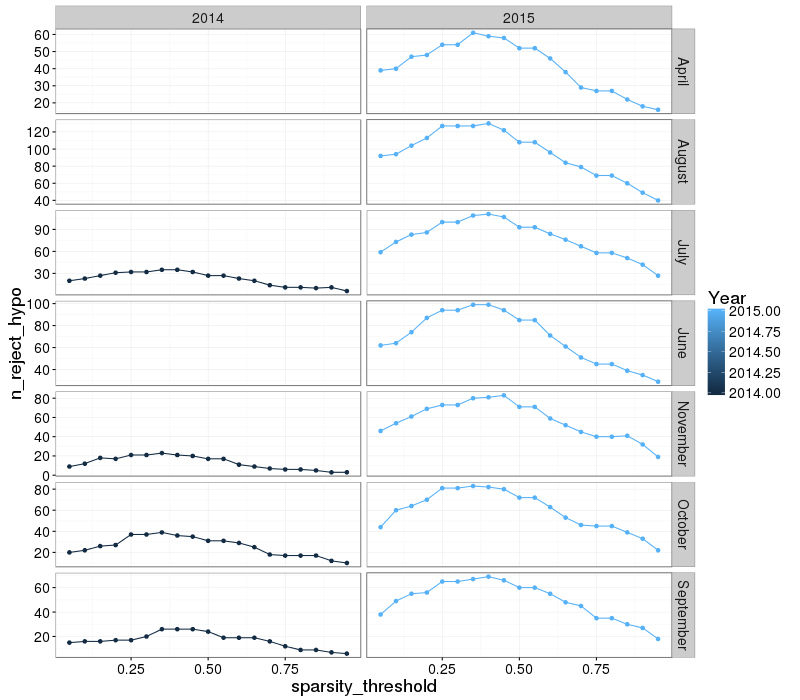

In [8]:
%%R -w 800 -h 700

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Year)) +
    geom_line(aes(color = Year)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

In [9]:
%%R
head(df.l2fc.rejH)

Source: local data frame [6 x 4]

  sparsity_threshold    Month  Year n_reject_hypo
               (dbl)   (fctr) (int)         (int)
1               0.05    April  2015            39
2               0.05   August  2015            92
3               0.05     July  2014            20
4               0.05     July  2015            59
5               0.05     June  2015            62
6               0.05 November  2014             9


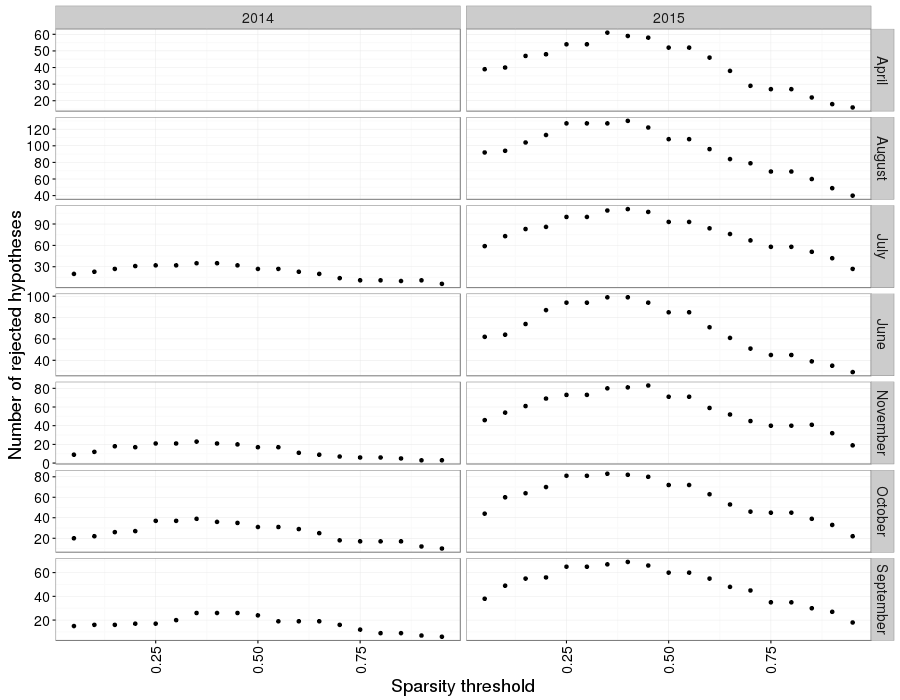

In [10]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Month = as.character(Month))

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point() +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Month ~ Year,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [11]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05           444
2               0.10           507
3               0.15           575


In [12]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.35


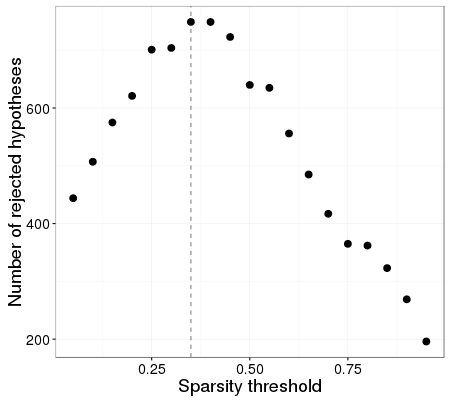

In [13]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [25]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 34715


In [26]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_BULK_0.25_.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_BULK_0.25_.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [17]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_BULK_0.25_.txt', sep='\t', header = TRUE)

In [18]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [19]:
%%R
df.l2fc$Month = factor(df.l2fc$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))


In [20]:
%%R
test = filter(df.l2fc, padj2<=0.10)
print(length(unique(test$OTU)))
print(length(unique(df.l2fc$OTU)))

[1] 285
[1] 5163


In [21]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Year, Till) %>% summarise(resp = n())
resp$treat = "a"
resp %>% ungroup() %>% arrange(resp) %>% as.data.frame

       Month Year Till resp treat
1   November 2014   NT    3     a
2  September 2014   NT    4     a
3    October 2014   NT    6     a
4       July 2014   NT   10     a
5  September 2015   NT   11     a
6      April 2015   NT   13     a
7   November 2015   NT   14     a
8     August 2015   NT   17     a
9    October 2015   NT   19     a
10  November 2014   PT   20     a
11 September 2014   PT   22     a
12      June 2015   NT   23     a
13      July 2014   PT   25     a
14      July 2015   NT   25     a
15   October 2014   PT   33     a
16     April 2015   PT   48     a
17 September 2015   PT   56     a
18   October 2015   PT   64     a
19  November 2015   PT   66     a
20      June 2015   PT   76     a
21      July 2015   PT   84     a
22    August 2015   PT  110     a


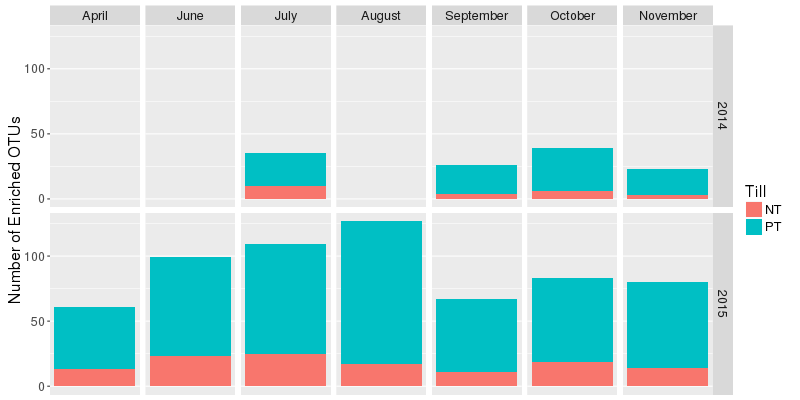

In [22]:
%%R -w 800 -h 400
p = ggplot(data = resp, aes(x = treat, y = resp)) +
    geom_bar(stat = 'identity', aes(fill = Till), position = 'stack') + facet_grid(Year~Month, scales = 'fixed')+
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL) + xlab(NULL)
p

In [23]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

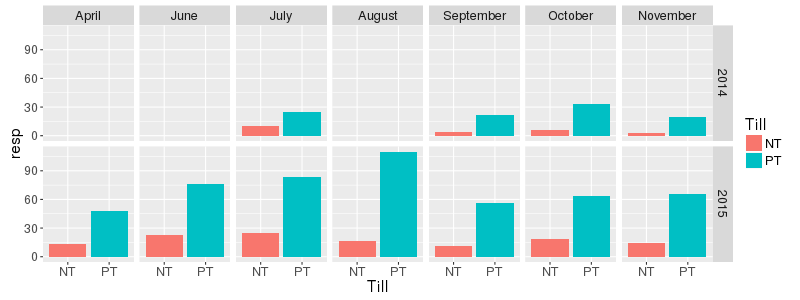

In [24]:
%%R -w 800 -h 300
ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month) +
    theme(text = element_text(size=16))

####Function arguments

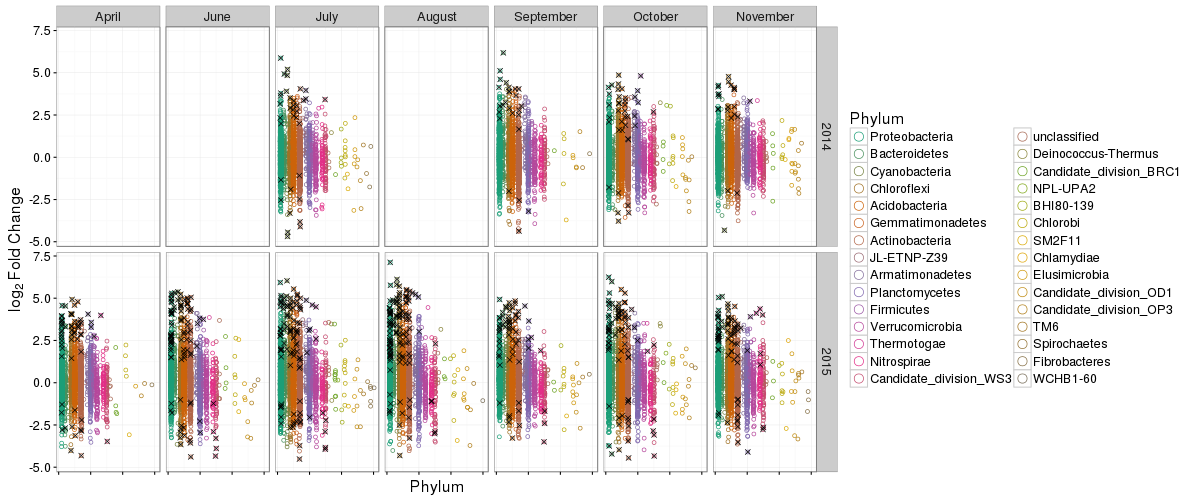

In [25]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

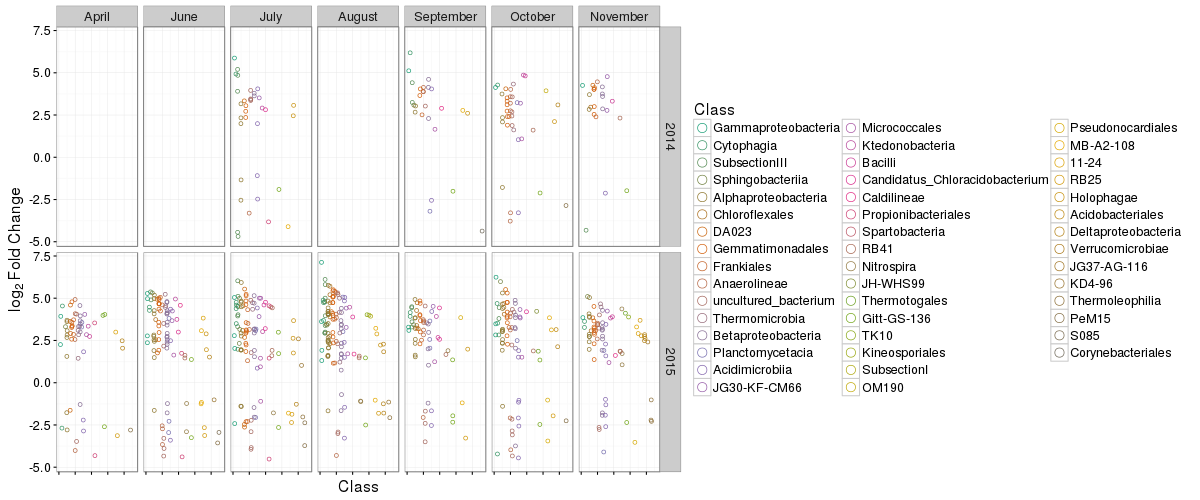

In [26]:
%%R -w 1200 -h 500
FDR = 0.10
d = filter(df.l2fc, padj2 <= FDR) 


d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= 0.05), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

In [27]:
%%R
re = filter(df.l2fc, padj2 <=0.10)
length(unique(re$OTU))

[1] 285


In [28]:
%%R
new_df.l2fc = df.l2fc

In [29]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

In [30]:
%%R
NT = filter(new_df.l2fc, Month == "November")
PT = filter(new_df.l2fc, Month == "November")
#length(unique(intersect(NT$OTU, PT$OTU)))
length((NT$OTU))

[1] 6307


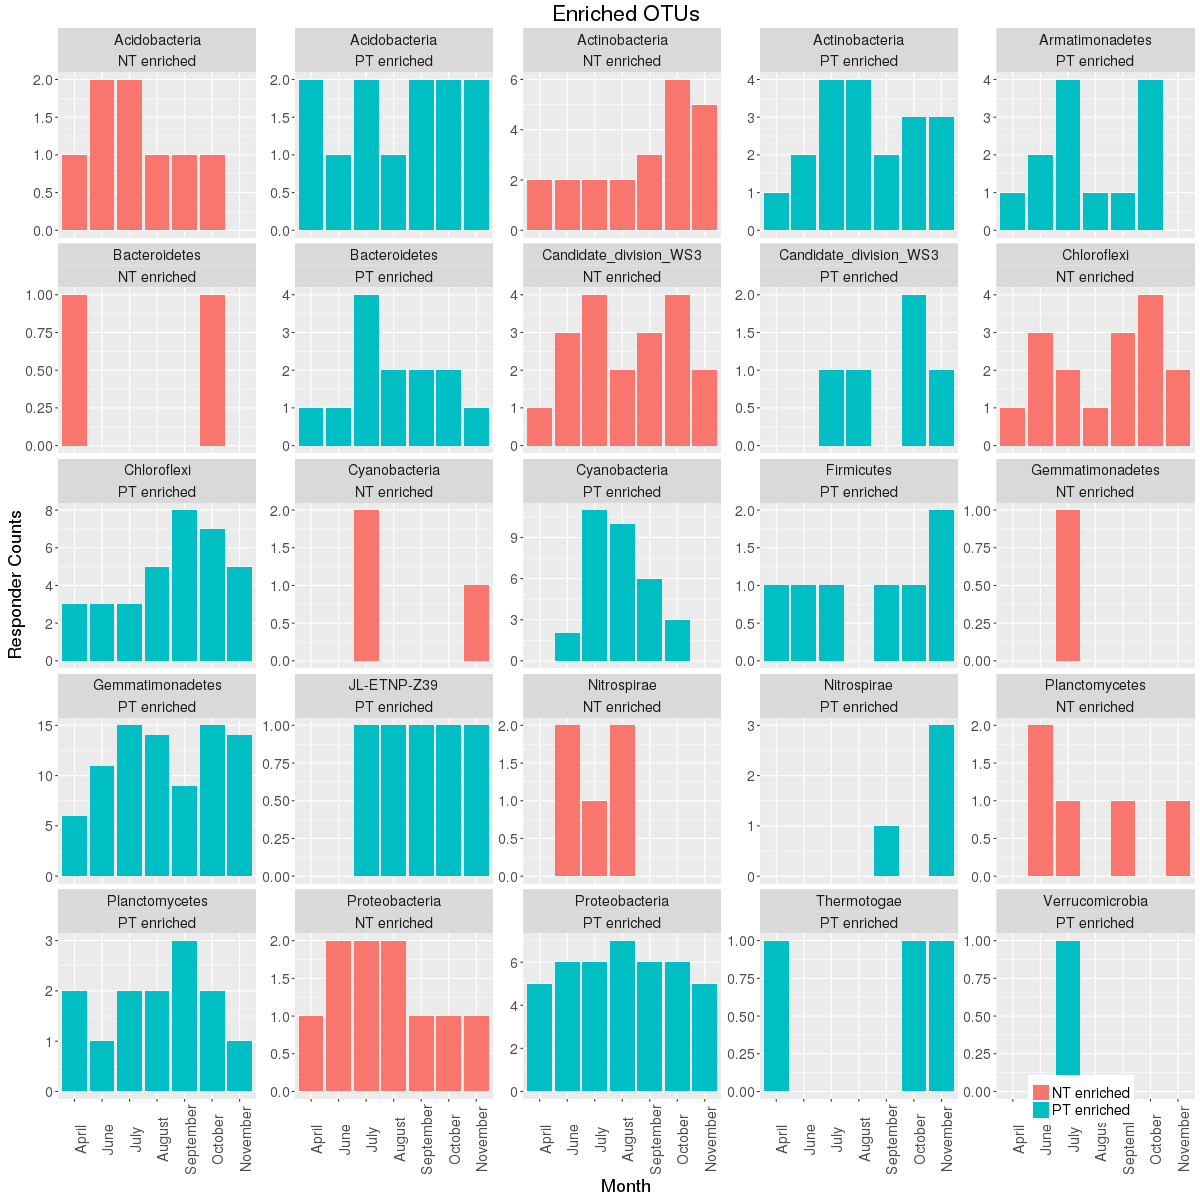

In [31]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank4, Rank3, Rank2, Month, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) 

#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#dcounts$Rank3 <- droplevels(dcounts$Rank3)
#dcounts$responders= as.numeric(dcounts$responders)
#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2 + Resp_status, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Month") + guides(fill=guide_legend(title=NULL)) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position=c(.9, 0)) 


p

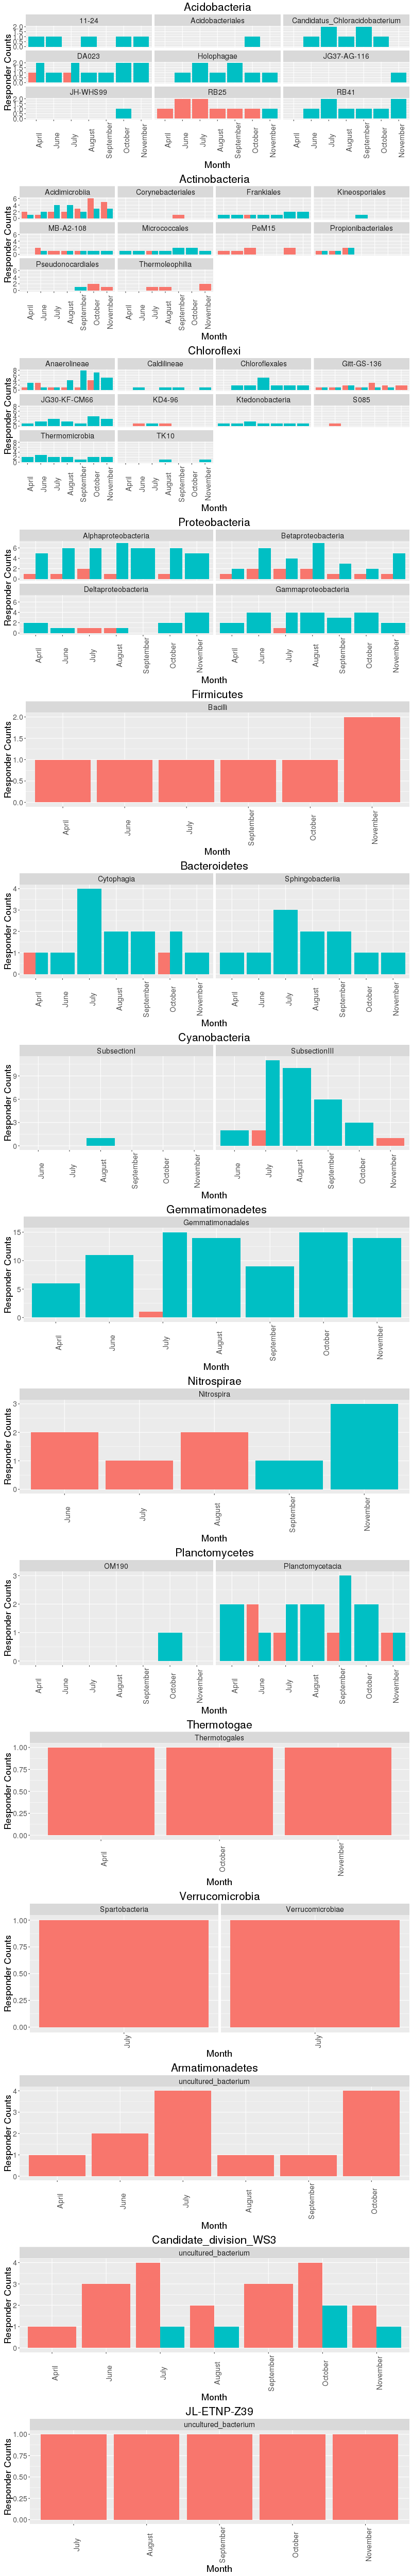

In [32]:
%%R -w 800 -h 5000

#scheme = iwanthue()

phyla = unique(dcounts$Rank2)
#t = "13CCPS"


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = Month , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity", position="dodge") + facet_wrap(~Rank3, scales = 'fixed') + 
    ggtitle(r) + ylab("Responder Counts")+
    xlab("Month") + guides(fill=guide_legend(title=NULL)) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position=c(1.2, 0)) }
    
plots.13CCPS = lapply(phyla, plot, d = dcounts)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

In [33]:
%%R
head(dcounts)

Source: local data frame [6 x 6]
Groups: Rank4, Rank3, Rank2, Month [6]

  Rank4      Rank3         Rank2     Month Resp_status responders
  (chr)      (chr)         (chr)    (fctr)       (chr)      (int)
1 32-20 Holophagae Acidobacteria      June PT enriched          1
2 32-20 Holophagae Acidobacteria      July PT enriched          2
3 32-20 Holophagae Acidobacteria    August PT enriched          1
4 32-20 Holophagae Acidobacteria September PT enriched          2
5 32-20 Holophagae Acidobacteria   October PT enriched          1
6 32-20 Holophagae Acidobacteria  November PT enriched          1


In [34]:
%%R
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(OTU, Rank2, Resp_status) %>%
          summarise(minP = min(padj2)) %>% 
          ungroup() %>%
          group_by(Rank2, Resp_status) %>%
          summarize(responders = sum((minP<= 0.10)))

dcounts %>% as.data.frame 


                    Rank2 Resp_status responders
1           Acidobacteria NT enriched          6
2           Acidobacteria PT enriched         18
3          Actinobacteria NT enriched         24
4          Actinobacteria PT enriched         22
5         Armatimonadetes PT enriched          4
6           Bacteroidetes NT enriched          2
7           Bacteroidetes PT enriched          9
8  Candidate_division_WS3 NT enriched          6
9  Candidate_division_WS3 PT enriched          4
10            Chloroflexi NT enriched          8
11            Chloroflexi PT enriched         35
12          Cyanobacteria NT enriched          3
13          Cyanobacteria PT enriched         14
14             Firmicutes PT enriched          2
15       Gemmatimonadetes NT enriched          1
16       Gemmatimonadetes PT enriched         22
17            JL-ETNP-Z39 PT enriched          2
18            Nitrospirae NT enriched          4
19            Nitrospirae PT enriched          3
20         Planctomy

In [35]:
%%R
ggsave(filename = "figs/PTvsNT_phyla_wmonths.png", plot = p, width =16, height =8)


Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/pytho

In [36]:
%%R
dcounts = df.l2fc %>%
          filter(padj2 <=0.10) %>%
          group_by(Till, Rank5, Rank4, Rank3, Rank2, Month) %>%
          summarize(responders = sum(padj2<= 0.10))
head(dcounts)

Source: local data frame [6 x 7]
Groups: Till, Rank5, Rank4, Rank3, Rank2 [3]

    Till             Rank5               Rank4           Rank3          Rank2
  (fctr)             (chr)               (chr)           (chr)          (chr)
1     NT         0319-6A21       Nitrospirales      Nitrospira    Nitrospirae
2     NT         0319-6A21       Nitrospirales      Nitrospira    Nitrospirae
3     NT             480-2 Solirubrobacterales Thermoleophilia Actinobacteria
4     NT             480-2 Solirubrobacterales Thermoleophilia Actinobacteria
5     NT             480-2 Solirubrobacterales Thermoleophilia Actinobacteria
6     NT Acidimicrobiaceae    Acidimicrobiales  Acidimicrobiia Actinobacteria
Variables not shown: Month (fctr), responders (int)


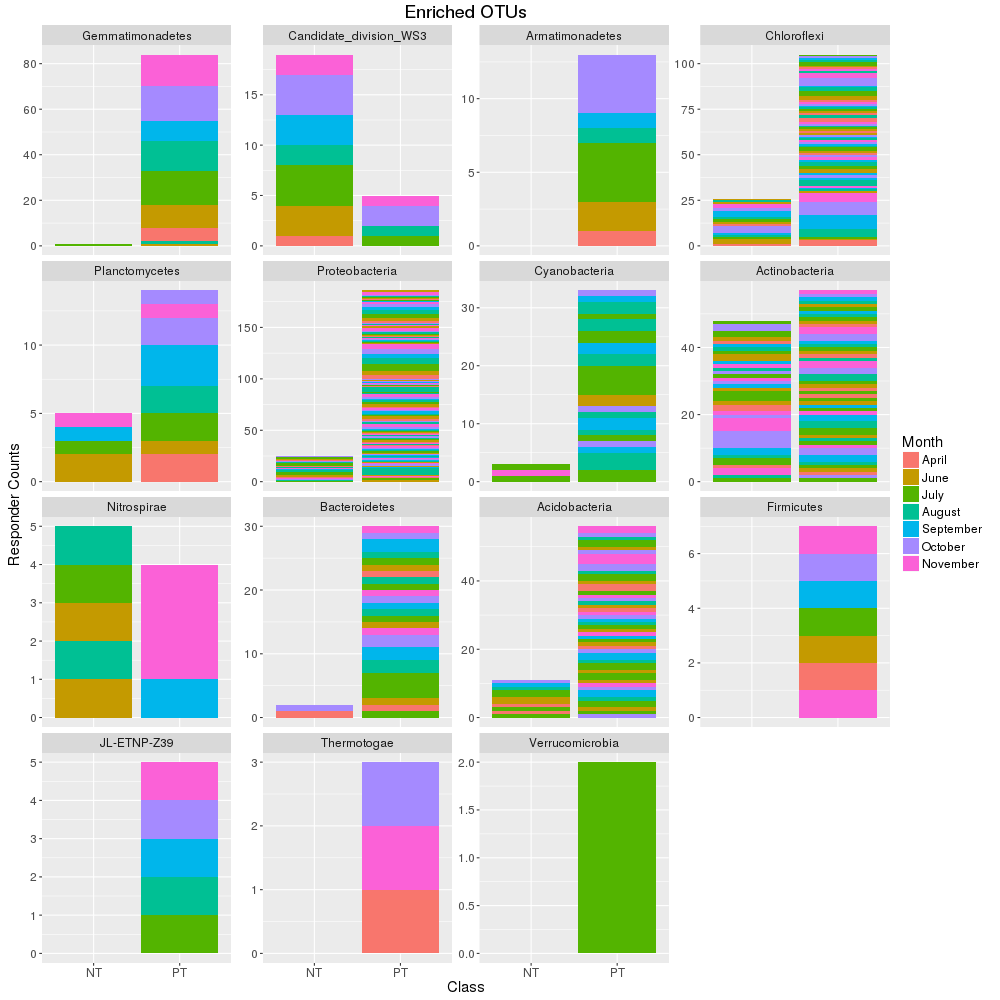

In [37]:
%%R -w 1000 -h 1000

dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, scales = "free_y") + ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Class") + guides(fill=guide_legend(title="Month"))+
    theme(text = element_text(size=15))


p

In [38]:
%%R
filter(df.l2fc, Rank2 == 'Verrucomicrobia') %>% arrange(-padj2) %>% head()

  Month Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
1  July 2014               0.35 OTU.16926    -0.03096063 0.8683922 0.9984514
2  July 2014               0.35   OTU.767    -0.92493095 0.6970283 0.5438419
3  July 2014               0.35 OTU.19530    -0.36850057 0.8045216 0.8750909
4  July 2014               0.35   OTU.779    -0.29582452 0.4454786 0.7963100
5  July 2014               0.35 OTU.12123    -0.74976851 0.8505167 0.7192813
6  July 2014               0.35  OTU.7182    -0.40719100 0.7569720 0.8495825
     Rank1           Rank2    Rank3      Rank4       Rank5    Rank6
1 Bacteria Verrucomicrobia Opitutae Opitutales Opitutaceae Opitutus
2 Bacteria Verrucomicrobia Opitutae Opitutales Opitutaceae Opitutus
3 Bacteria Verrucomicrobia Opitutae Opitutales Opitutaceae Opitutus
4 Bacteria Verrucomicrobia Opitutae Opitutales Opitutaceae Opitutus
5 Bacteria Verrucomicrobia Opitutae Opitutales Opitutaceae Opitutus
6 Bacteria Verrucomicrobia Opitutae Opitutales Opitut

In [39]:
%%R
ggsave(filename = "figs/PTvsNT_phyla.png", plot = p, width =14, height =14)


Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 50 or more warnings (use warnings() to see the first 50)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


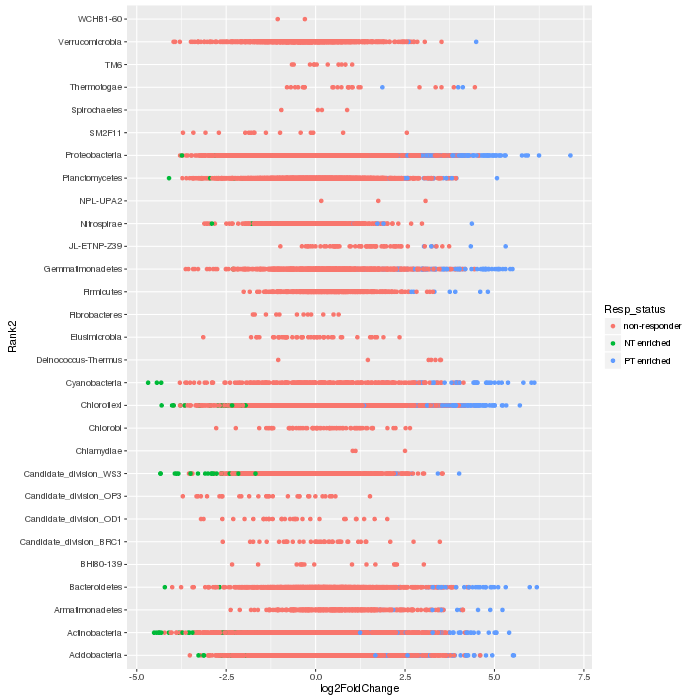

In [40]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

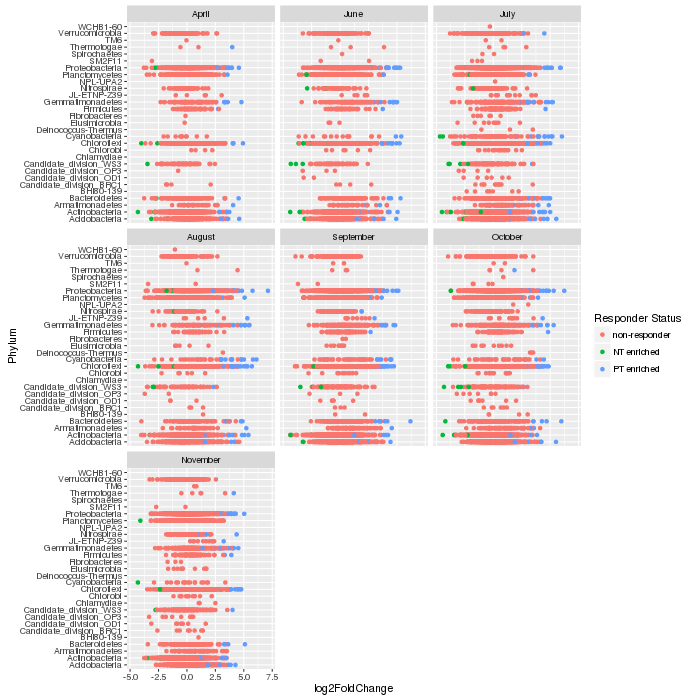

In [41]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

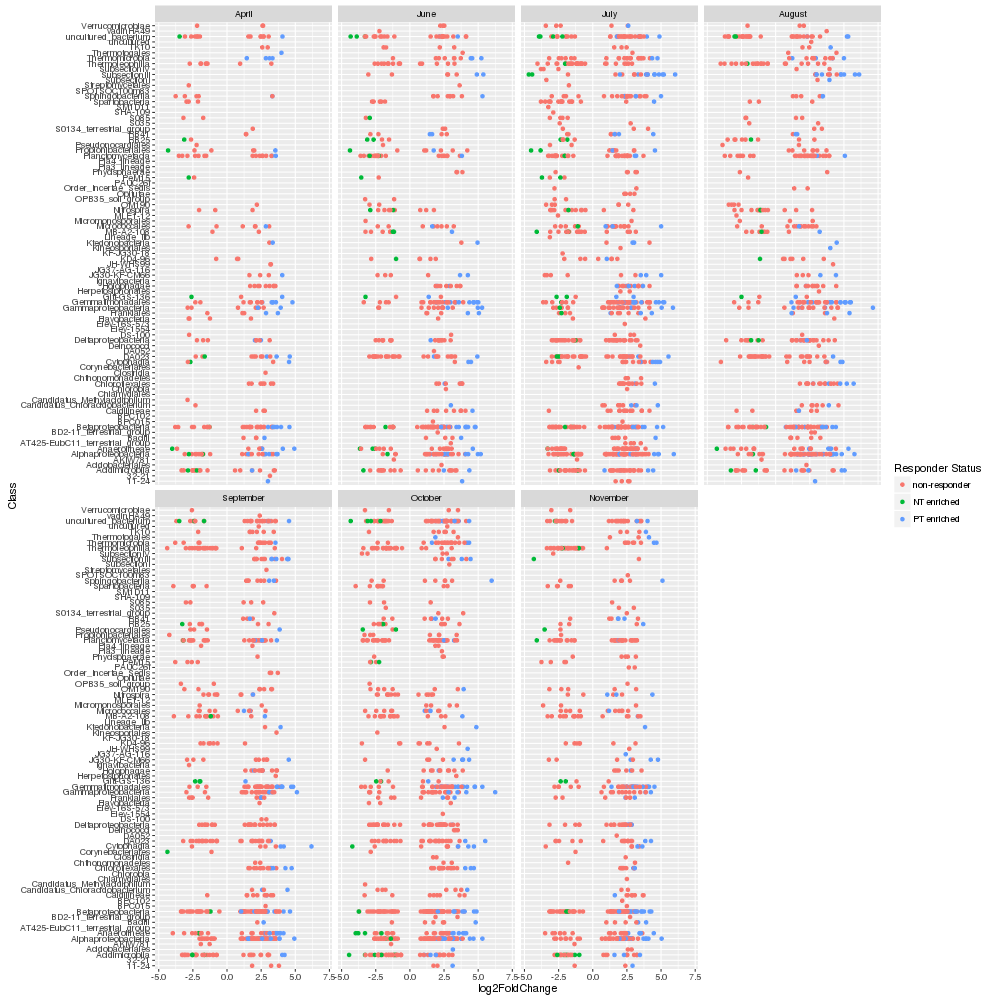

In [42]:
%%R -w 1000 -h 1000
new_df.l2fc_2 = filter(new_df.l2fc, padj <=0.10)
p = ggplot(new_df.l2fc_2, aes(log2FoldChange, Rank3))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month, ncol = 4)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Class")
p

In [43]:
%%R
ggsave(filename = "figs/NT_PT_phyla.png", plot = p, width =10, height =3)


Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 47 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 47 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 3: Removed 13 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [44]:
%%R -w 700 -h 700
July = filter(new_df.l2fc, Month == "July") %>%
        group_by(OTU) 
Sept = filter(new_df.l2fc, Month == "September")%>%
        group_by(OTU)
JS2 = right_join(July, Sept, by = "OTU")

In [45]:
%%R
JS2$Resp_status[JS2$padj.x > 0.10 & JS2$padj.y >0.10] = "unknown/non-responder"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "NT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "PT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y > 0.10] = "PT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "PT responder Sept"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y < 0.10] = "NT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "NT responder Sept"

In [46]:
%%R
head(JS2)

Source: local data frame [6 x 36]
Groups: OTU [4]

  Month.x Year.x sparsity_threshold.x       OTU log2FoldChange.x   lfcSE.x
   (fctr)  (int)                (dbl)    (fctr)            (dbl)     (dbl)
1    July   2014                 0.35   OTU.778      -0.61597423 0.5124907
2    July   2015                 0.35   OTU.778       0.04028019 0.4601475
3      NA     NA                   NA  OTU.5511               NA        NA
4    July   2014                 0.35  OTU.2180       0.08880429 0.7413839
5    July   2015                 0.35  OTU.2180      -1.06435362 0.9645138
6    July   2015                 0.35 OTU.12365      -1.21318733 0.8246331
Variables not shown: padj.x (dbl), Rank1.x (fctr), Rank2.x (chr), Rank3.x
  (chr), Rank4.x (chr), Rank5.x (chr), Rank6.x (chr), Rank7.x (chr), Rank8.x
  (fctr), padj2.x (dbl), Till.x (fctr), Resp_status.x (chr), Month.y (fctr),
  Year.y (int), sparsity_threshold.y (dbl), log2FoldChange.y (dbl), lfcSE.y
  (dbl), padj.y (dbl), Rank1.y (fctr), Rank2.

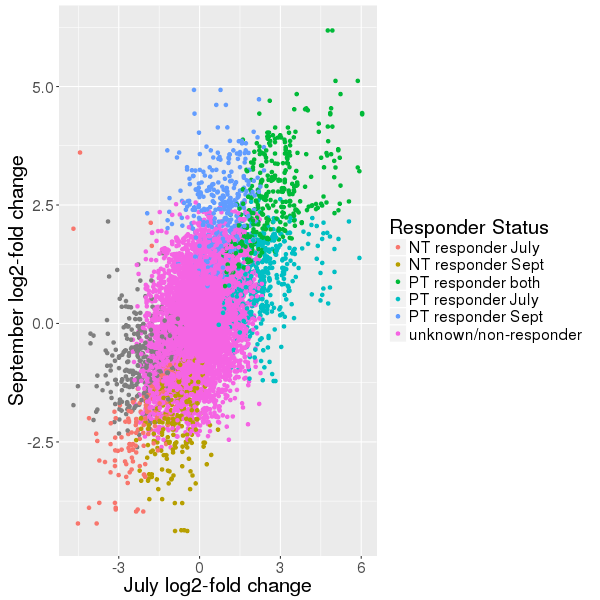

In [47]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

In [48]:
%%R
Sept = filter(new_df.l2fc, Month == "September") %>%
        group_by(OTU) 
Oct = filter(new_df.l2fc, Month == "October")%>%
        group_by(OTU)
SO = right_join(Sept, Oct, by = "OTU")

In [49]:
%%R
SO$Resp_status[SO$padj.x > 0.10 & SO$padj.y >0.10] = "unknown/non-responder"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "NT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "PT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y > 0.10] = "PT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "PT responder Oct"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y > 0.10] = "NT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "NT responder Oct"

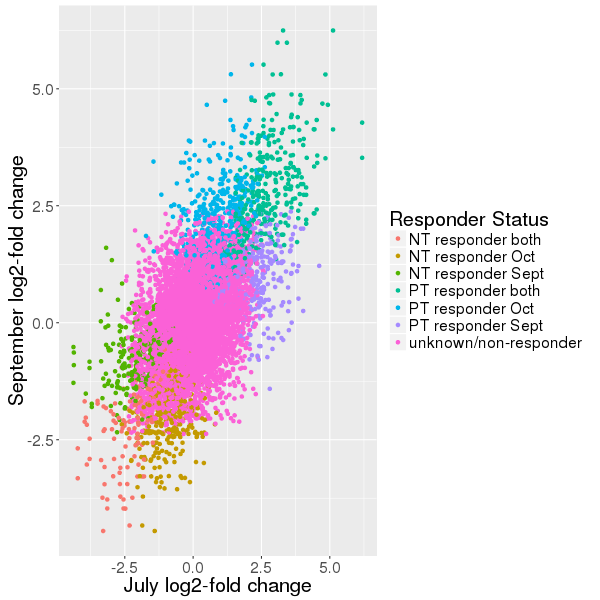

In [50]:
%%R -w 600 -h 600
p = ggplot(SO, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

## Blasting against Living Tree Project db

In [51]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [52]:
from cogent import LoadSeqs, DNA


In [53]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.162
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAATCTGGGGGCTCAACCCCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGATCTCTGGGCCGTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGTTGGGAACTAGATGTGGGGACCATTCCACGGTCTCCGTGTCGCAGCTAACGCATTAAGTTCCCCGCCTGGGGAGTACGGCCGCAAGGCTA
>OTU.239
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATAGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGATAACTAGCTGTCTGGGTGCTTGGCACTTAGGTGGCGCAGCTAACGCATTAAGTTATCCGCCTGGGGAGTACGGTCGCAAGATTA
>OTU.2456
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATATAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTATGTGTCTTGAATATCGCGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCGATTGCGAAGGCAGCTTACTACACGATCATTGACG

In [54]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [55]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /var/seq_data/silva/silva_blastdb/silva_RefNR_115 -num_threads 5


('', '')

In [56]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

OTU.162	HQ256829	100.000	375	0	0	1	375	445	819	0.0	693
3000 otusn_silvaRefNR115.m6
500


In [57]:
from IPython.display import Image
import pandas.rpy.common as com

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


In [58]:
%%R
library(data.table)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘data.table’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:reshape2’:

    dcast, melt


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106:

In [59]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))


Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 474 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 731 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [60]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)


Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(top_hits_df_LTP) : object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [61]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [62]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)


Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [63]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [64]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [65]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")